# ISM-FLUX simulations

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from brighteyes_ism.simulation.PSF_sim import SPAD_PSF_2D, simSettings
from scipy.optimize import minimize

# import functions from files
# requires multiprocessing, joblib, scipy, tensorflow, PyFocus
import CRB
import fitDoughnut2D
import shift2Darray
import csv2array
from mpl_toolkits.axes_grid1 import make_axes_locatable
from calcDistFromCoord import calcDistFromCoord
from detectionEff import detectionEff

## MINFLUX
First, we reproduce the original MINFLUX experiment, Fig. S2, Balzarotti et al., Science, 2017

### Input parameters

In [2]:
# simulation grid settings
Nx = 1024
Ny = Nx
pxsize = 1 # nm

# laser beam positions
L = 100 # diameter of the targeted coordinate pattern (nm)
phi = np.array([120, 240, 0, 0]) # phi coordinates of the TCP, here triangle + center (degrees)

# optical settings
exwavelength = 640 # nm
emwavelength = 680 # nm
NA = 1.4
M = 500 # overall magnification of the system (100x obj + 5x extra magnification)

# SPAD detector settings
pxpitch = 75e3 # nm - spad array pixel pitch (real space)
pxdim = 50e3 # nm - spad pixel size (real space)
N = 5 # number of pixels in the detector in each dimension (5x5 typically)
ff = (N * pxdim)**2 / (N * pxpitch  - (pxpitch - pxdim))**2 # fill factor

### Calculate likelihood map for a given series of observed photon counts

In [3]:
# Generate doughnut beams using analytical approximation
sigmaDoughnut = 200 / 300 * 128 / pxsize # convert fhwm of 200 nm to sigma
PSF = fitDoughnut2D.doughnut2D(Ny, Nx, int(Nx/2), int(Nx/2), 1, sigmaDoughnut,0)

# TCP parameters
dist = L / 2
fwhm = 2 * np.sqrt(2 * np.log(2)) * sigmaDoughnut

phir = phi * np.pi / 180
distP = dist / pxsize
r = [distP, distP, distP, 0]

# shifts in x and y (units of pixels) for generating the TCP
shiftx = np.round(r * np.cos(phir))
shifty = np.round(r * np.sin(phir))

# exPSF = [4 x 1024 x 1024] array with the four excitation doughnut beams of the TCP
exPSFref = np.zeros((len(r), Ny, Nx))
for i in range(len(r)):
    exPSFref[i, :, :] = shift2Darray.shift2Darray(PSF, [shiftx[i], -shifty[i]], bc=None)

# normalize exPSF
for i in range(len(r)):
    exPSFref[i, :, :] /= np.sum(exPSFref[i, :, :])

# calculate likelihood for a given number of photons assuming a TCP of 3 positions without the center
lh = CRB.loclikelihood(exPSFref[0:3, :, :], [8, 6, 12], 1000000)
c = int(Nx / 2 - 1)
for i in range(len(r)-1):
    # show position of the beams
    lh[int(c+shifty[i]-1):int(c+shifty[i]+1), int(c+shiftx[i]-1):int(c+shiftx[i]+1)] = np.max(lh)

# calculate likelihood for a given number of photons assuming a TCP of 4 positions including the center
lh2 = CRB.loclikelihood(exPSFref, [8, 6, 12, 0], 1000000)
for i in range(len(r)):
    lh2[int(c+shifty[i]-1):int(c+shifty[i]+1), int(c+shiftx[i]-1):int(c+shiftx[i]+1)] = np.max(lh2)

# calculate CRB
[sigma_CRBref, sigmax, sigmay] = CRB.CRB(exPSFref, 1000000, pxsize, 100)

### Plot results

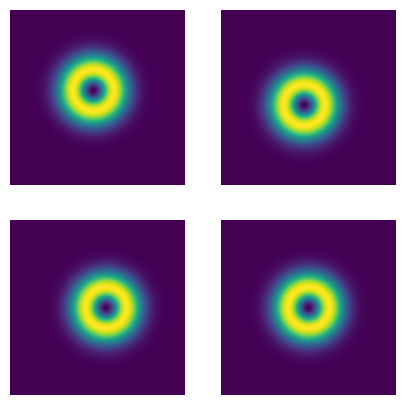

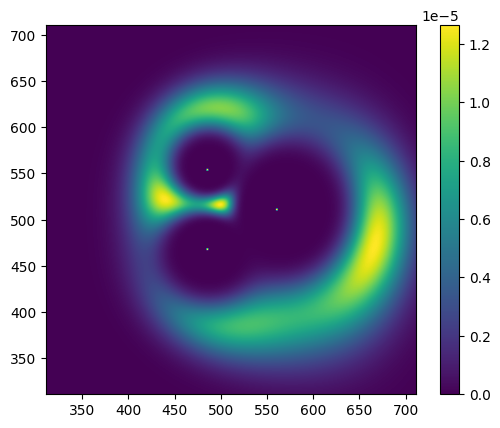

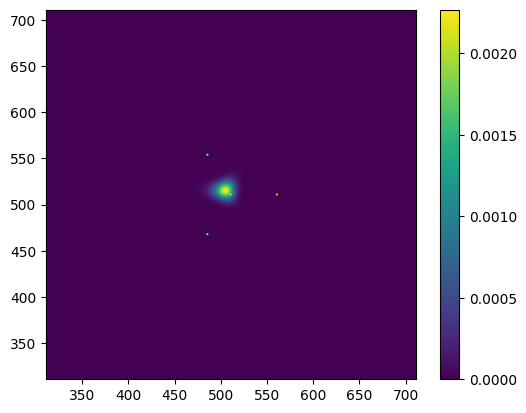

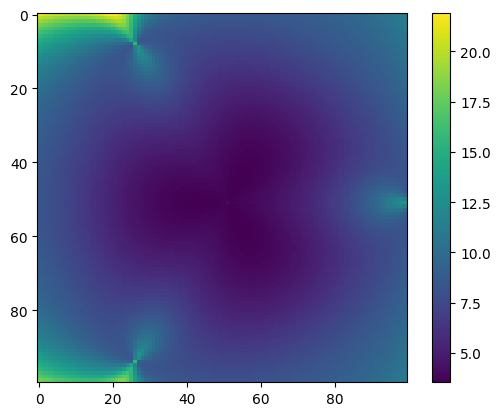

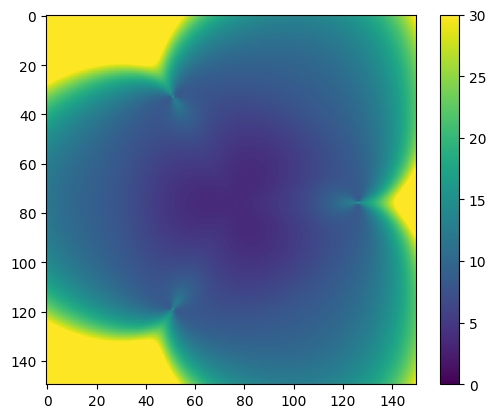

In [4]:
fig = plt.figure(figsize=(5,5))
for i in range(len(r)):
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow(exPSFref[i, :,:])
    plt.axis('off')

start = c - 200
stop = c + 200
    
plt.figure()
plt.imshow(lh)
plt.colorbar()
plt.xlim([start, stop])
plt.ylim([start, stop])

plt.figure()
plt.imshow(lh2)
plt.colorbar()
plt.xlim([start, stop])
plt.ylim([start, stop])

plt.figure()
plt.imshow(sigma_CRBref[c-50:c+50, c-50:c+50])
plt.colorbar()

plt.figure()
plt.imshow(sigma_CRBref[c-75:c+75, c-75:c+75], vmin=0, vmax=30)
plt.colorbar()

## ISM-FLUX

### Calculate PSFs (this may take an hour)

In [5]:
pxsize = 2 # nm
Nx = 1024

exOps = simSettings()
exOps.na = NA   # numerical aperture
exOps.wl = exwavelength   # wavelength [nm]
exOps.mask = 'VP'
exOps.gamma = 45 # parameter describing the light polarization
exOps.beta = 90  # parameter describing the light polarization

emOps = simSettings()
emOps.na = NA   # numerical aperture
emOps.wl = emwavelength   # wavelength [nm]
emOps.gamma = 45 # parameter describing the light polarization
emOps.beta = 90  # parameter describing the light polarization

In [6]:
[PSF, detPSF, exPSF] = SPAD_PSF_2D(N, Nx, pxpitch, pxdim, pxsize, M, exOps, emOps, return_entrance_field = False)

Calculating field near the focus:


XY plane: 100%|██████████████████████████████████████████████████████████████████| 1024/1024 [1:33:33<00:00,  5.48s/it]


Calculating field near the focus:


XY plane: 100%|██████████████████████████████████████████████████████████████████| 1024/1024 [1:32:27<00:00,  5.42s/it]


In [7]:
detPSF = np.moveaxis(detPSF, 2, 0)
PSF = np.moveaxis(PSF, 2, 0)

#### Excitation PSF

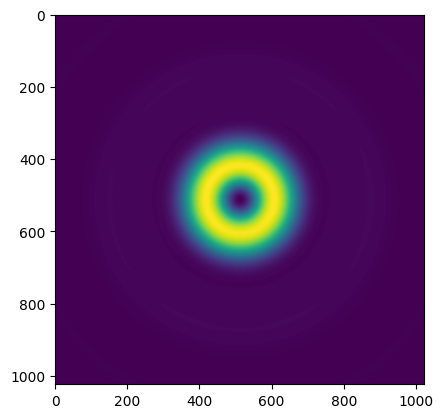

In [8]:
h = plt.imshow(exPSF)

#### Detection PSF

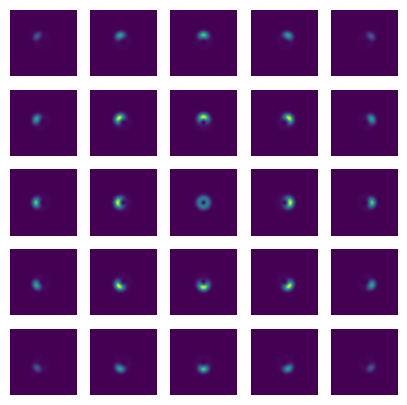

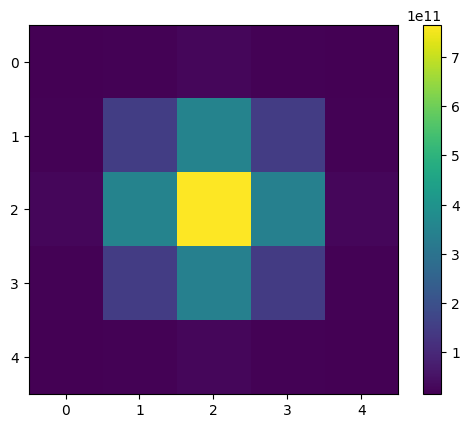

In [9]:
fig = plt.figure(figsize=(5,5))
for i in range(N*N):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(PSF[i, :,:], vmin=0, vmax=np.max(PSF))
    plt.axis('off')

plt.figure()
plt.imshow(np.reshape(detPSF[:,int(Nx/2), int(Nx/2)], (5, 5)))
plt.colorbar()

### Calculate CRB for different L values
First, we assume a total of 1000 emitted photons, regardless of the molecule's position and 0 background.

In [10]:
Ns = 100 # number of signal photons
Llist = [12, 20, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400] # nm

In [14]:
exPSFSingle = exPSF

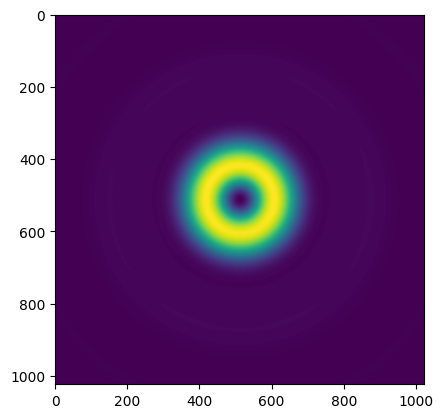

In [15]:
plt.imshow(exPSFSingle)

In [16]:
minfluxcrb = np.zeros((len(Llist), Nx, Nx))
smSPADcrb = np.zeros((len(Llist), Nx, Nx))
exPSFsum = np.zeros((len(Llist), Nx, Nx))
it = 0
phir = phi * np.pi / 180

for L in Llist:
    print(str(L), end=" ")
    dist = L / 2 # nm
    distP = dist / pxsize
    r = [distP, distP, distP, 0]

    shiftx = r * np.cos(phir)
    shifty = r * np.sin(phir)

    # excitation PSFs
    exPSF = np.zeros((len(r), Ny, Nx))
    for i in range(len(r)):
        exPSF[i, :, :] = shift2Darray.shift2Darray(exPSFSingle, [np.floor(shiftx[i]), np.floor(-shifty[i])], bc='periodic')
    for i in range(len(r)):
        exPSF[i, :, :] /= np.sum(exPSF[i, :, :])
    exPSFsum[it, :, :] = np.sum(exPSF, 0)
    
    [sigmaExc_CRB, sigmax, sigmay] = CRB.CRB(exPSF, 100000, pxsize, Ns)
    
    minfluxcrb[it, :, :] = sigmaExc_CRB
    
    PSF = np.zeros((len(r)*N*N, Nx, Nx))
    k = 0
    for i in range(len(r)):
        for j in range(N*N):
            PSF[k, :, :] = exPSF[i, :, :] * detPSF[j, :,:]
            k += 1

    PSF = np.clip(PSF, np.min(PSF[PSF>0]), np.max(PSF))
    PSF /= np.sum(PSF)

    [sigmaAll_CRB, sigmax, sigmay] = CRB.CRB(PSF, 100000, pxsize, Ns)
    
    smSPADcrb[it, :, :] = sigmaAll_CRB
    it += 1

12 20 50 75 100 125 150 200 250 300 350 400 

In [17]:
Nx = 1024
SPADsize = (N - 1) * pxpitch + pxdim # nm
SPADsizeP = SPADsize / M / pxsize
SPADradiusP = np.round(SPADsizeP / 2)
rmin = int(Nx / 2 - 1.1 * SPADradiusP)
rmax = int(Nx / 2 + 1.1 * SPADradiusP)
plotL = [0, 2, 4, 6, 8, 11]
Nl = len(plotL)
Nc = 5 # number of figure columns

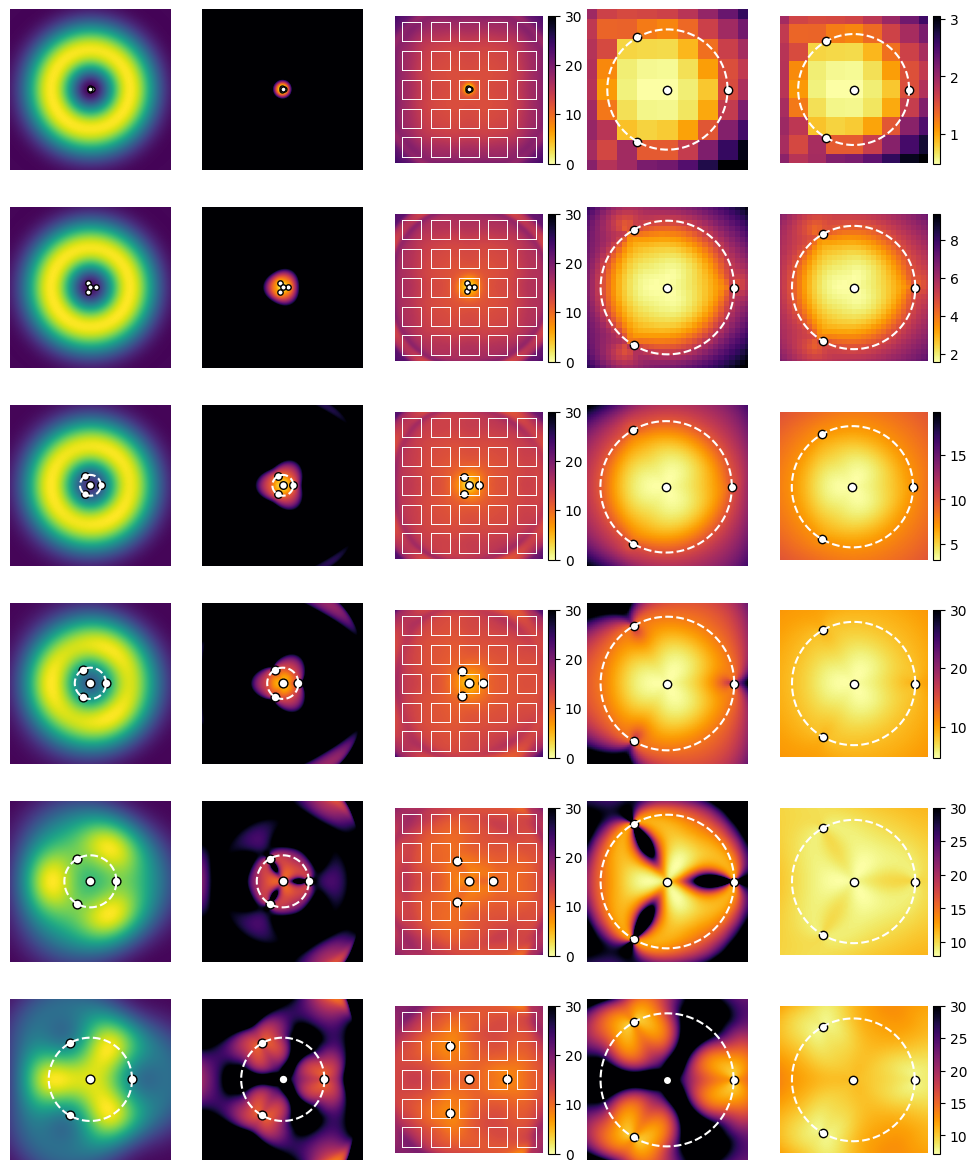

In [43]:
csize = [13, 15, 30, 40, 40, 40, 40]

fig, axarr = plt.subplots(Nl, Nc, figsize=(12/5*Nc, 30/12*Nl))
for jj in range(len(plotL)):
    i = plotL[jj]
    col = -1
    L = Llist[i]
    dist = L / 2 # nm
    distP = dist / pxsize
    dv = np.max((int(L / 2 / pxsize), 0))
    r = [distP, distP, distP, 0]
    shiftx = r * np.cos(phir)
    shifty = r * np.sin(phir)
    
    # -------------------- Total excitation intensity - zoomed --------------------
    #ax = fig.add_subplot(Nl, Nc, Nc*i+1)
    col += 1
    vmax = np.max(exPSFsum[i,rmin:rmax, rmin:rmax])
    vmin = np.min(exPSFsum[i,rmin:rmax, rmin:rmax])
    axarr[jj, col].imshow(exPSFsum[i,:,:], cmap='viridis', vmin=np.min(exPSFsum[i,:,:]), vmax=np.max(exPSFsum[i,:,:]))
    # add circles
    rx = [Nx/2 + distP * np.cos(alpha * np.pi / 180) for alpha in range(360)]
    ry = [Nx/2 + distP * np.sin(alpha * np.pi / 180) for alpha in range(360)]
    if jj > 1:
        axarr[jj, col].plot(rx, ry, '--', color='white')
    # add positions
    for j in range(len(r)):
        axarr[jj, col].scatter(Nx/2+shiftx[j], Nx/2-shifty[j], color='white', edgecolors='black', s=csize[jj])    
    axarr[jj, col].axis('off')
    rminz = int(Nx / 2 - 1.1 * SPADradiusP)
    rmaxz = int(Nx / 2 + 1.1 * SPADradiusP)
    axarr[jj, col].set_xlim([rminz, rmaxz])
    axarr[jj, col].set_ylim([rminz, rmaxz])
    
    # -------------------- CRB plot MINFLUX - SAME COLOR SCALE --------------------
    col += 1
    rmin = int(Nx / 2 - 1.1 * SPADradiusP)
    rmax = int(Nx / 2 + 1.1 * SPADradiusP)
    cmap1 = list(np.linspace(0, 40, 200))
    cmap2 = list(np.logspace(np.log10(40), np.log10(np.max(minfluxcrb[:,rmin:rmax, rmin:rmax])), 57))
    cmapTot = cmap1 + cmap2[1:]
    vmax = 40
    axarr[jj, col].imshow(minfluxcrb[i,:,:], cmap='inferno_r', vmin=0, vmax=30)
    axarr[jj, col].axis('off')
    axarr[jj, col].set_xlim([rmin, rmax])
    axarr[jj, col].set_ylim([rmin, rmax])
    # add circles
    rx = [Nx/2 + distP * np.cos(alpha * np.pi / 180) for alpha in range(360)]
    ry = [Nx/2 + distP * np.sin(alpha * np.pi / 180) for alpha in range(360)]
    if jj > 1:
        axarr[jj, col].plot(rx, ry, '--', color='white')
    # add positions
    for j in range(len(r)):
        axarr[jj, col].scatter(Nx/2+shiftx[j], Nx/2-shifty[j], color='white', edgecolors='black', s=csize[jj])
    
    # -------------------- CRB plot SM-SPAD - SAME COLOR SCALE --------------------
    col += 1
    data = axarr[jj, col].imshow(smSPADcrb[i,:,:], cmap='inferno_r', vmin=0, vmax=30)
    axarr[jj, col].axis('off')
    axarr[jj, col].set_xlim([rmin, rmax])
    axarr[jj, col].set_ylim([rmin, rmax])
    divider = make_axes_locatable(axarr[jj, col])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(data, cax=cax, ticks=[0, 10, 20, 30, 40, 50, 60])
    # add circles
    rx = [Nx/2 + distP * np.cos(alpha * np.pi / 180) for alpha in range(360)]
    ry = [Nx/2 + distP * np.sin(alpha * np.pi / 180) for alpha in range(360)]
    #ax.plot(rx, ry, '--', color='white')
    # add positions
    for j in range(len(r)):
        axarr[jj, col].scatter(Nx/2+shiftx[j], Nx/2-shifty[j], color='white', edgecolors='black', s=csize[jj])

    lw = 0.7
    startc = Nx/2 - SPADradiusP
    SPADsizeP = (pxdim * 5 / N) / M / pxsize
    for j in range(N):
        startx = startc + j * (pxpitch * 5 / N) / M / pxsize
        for k in range(N):
            starty = startc + k * (pxpitch * 5 / N) / M / pxsize
            axarr[jj, col].plot([startx, startx + SPADsizeP], [starty, starty], '-', color='white', linewidth=lw)
            axarr[jj, col].plot([startx, startx + SPADsizeP], [starty + SPADsizeP, starty + SPADsizeP], '-', color='white', linewidth=lw)
            axarr[jj, col].plot([startx, startx], [starty, starty + SPADsizeP], '-', color='white', linewidth=lw)
            axarr[jj, col].plot([startx + SPADsizeP, startx + SPADsizeP], [starty, starty + SPADsizeP], '-', color='white', linewidth=lw)

    # -------------------- CRB plot MINFLUX --------------------
    rmin = int(Nx/2 - 1.2*dv)
    rmax = int(Nx/2 + 1.2*dv + 1)
    col += 1
    vmax = np.max(minfluxcrb[i,rmin:rmax, rmin:rmax]) # np.max(minfluxcrb[i,rmin:rmax, rmin:rmax])
    vmin = np.min(smSPADcrb[i,rmin:rmax, rmin:rmax]) # np.min(minfluxcrb[i,rmin:rmax, rmin:rmax])
    if vmax > 30:
        vmax = 30
        cmap1 = list(np.linspace(vmin, 15, 200))
        cmap2 = list(np.logspace(np.log10(15), np.log10(vmax), 57))
        cmapTot = cmap1 + cmap2[1:]
    else:
        cmapTot = list(np.linspace(vmin, vmax, 256))
        
    axarr[jj, col].imshow(minfluxcrb[i,:,:], cmap='inferno_r', vmax=vmax)
    axarr[jj, col].axis('off')
    axarr[jj, col].set_xlim([rmin, rmax])
    axarr[jj, col].set_ylim([rmin, rmax])
    
    # add circles
    rx = [Nx/2 + distP * np.cos(alpha * np.pi / 180) for alpha in range(360)]
    ry = [Nx/2 + distP * np.sin(alpha * np.pi / 180) for alpha in range(360)]
    axarr[jj, col].plot(rx, ry, '--', color='white')
    # add positions
    for j in range(len(r)):
        axarr[jj, col].scatter(Nx/2+shiftx[j], Nx/2-shifty[j], color='white', edgecolors='black')
    #print("vmin = " + str(vmin))
    #print("vmax = " + str(vmax))
    
    # -------------------- CRB plot SM-SPAD --------------------
    col += 1
    #vmax = np.max(smSPADcrb[i,rmin:rmax, rmin:rmax])
    #vmin = np.min(smSPADcrb[i,rmin:rmax, rmin:rmax])
    data = axarr[jj, col].imshow(smSPADcrb[i,:,:], cmap='inferno_r', vmax=vmax)
    axarr[jj, col].axis('off')
    axarr[jj, col].set_xlim([rmin, rmax])
    axarr[jj, col].set_ylim([rmin, rmax])
    divider = make_axes_locatable(axarr[jj, col])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(data, cax=cax)
    # add circles
    rx = [Nx/2 + distP * np.cos(alpha * np.pi / 180) for alpha in range(360)]
    ry = [Nx/2 + distP * np.sin(alpha * np.pi / 180) for alpha in range(360)]
    axarr[jj, col].plot(rx, ry, '--', color='white')
    # add positions
    for j in range(len(r)):
        axarr[jj, col].scatter(Nx/2+shiftx[j], Nx/2-shifty[j], color='white', edgecolors='black')
            
#plt.savefig("CRB_vs_L_new.svg")

(0.0, 40.0)

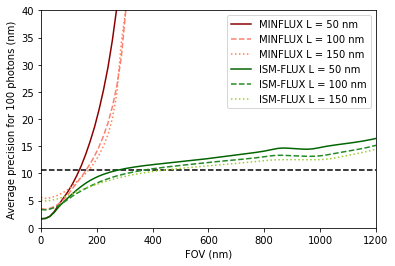

In [55]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

redc = ['darkred', 'salmon', 'coral']
greenc = ['darkgreen', 'forestgreen', 'yellowgreen']
labelr = ['MINFLUX L = 50 nm', 'MINFLUX L = 100 nm', 'MINFLUX L = 150 nm']
labelg = ['ISM-FLUX L = 50 nm', 'ISM-FLUX L = 100 nm', 'ISM-FLUX L = 150 nm']
line = ['-', '--', ':']

ax.plot([0, 1200], [106/np.sqrt(Ns), 106/np.sqrt(Ns)], '--', color='k')

i = 0
for L in [2, 4, 6]:
    # L = 50, 100, 150 nm
    x = []
    y = []
    for distpx in range(150):
        x.append(2*4*distpx*pxsize) # x2 -> diameter
        if distpx == 0:
            y.append(minfluxcrb[L,512,512])
        else:
            y.append(np.mean(minfluxcrb[L,calcDistFromCoord(minfluxcrb[L,:,:], [512,512]) < 4*distpx]))
    ax.plot(x, y, c=redc[i], label=labelr[i], linestyle=line[i])
    i += 1

i = 0
for L in [2, 4, 6]:
    y = []
    for distpx in range(150):
        if distpx == 0:
            y.append(smSPADcrb[L,512,512])
        else:
            y.append(np.mean(smSPADcrb[L,calcDistFromCoord(smSPADcrb[L,:,:], [512,512]) < 4*distpx]))
    ax.plot(x, y, c=greenc[i], label=labelg[i], linestyle=line[i])
    i += 1
    
ax.set_ylabel('Average precision for 100 photons (nm)')
ax.set_xlabel('FOV (nm)')
ax.legend()
ax.set_xlim([0, 1200])
ax.set_ylim([0, 40])

#plt.savefig("CRB_vs_FOV_line_plots.svg")

## Multiplexing

In [20]:
pde = detectionEff(detPSF[12,:,:], SPADsize / M / pxsize, 4)
pde = pde / np.max(pde)

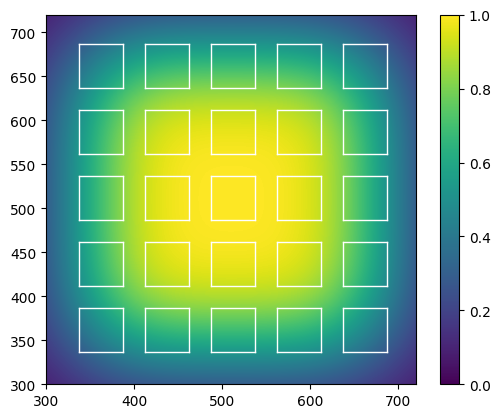

In [21]:
plt.imshow(pde, vmin=0, vmax=1)
lw = 1

# add SPAD projection
startc = Nx/2 - SPADradiusP
SPADelP = pxdim / M / pxsize
for j in range(N):
    startx = startc + j * pxpitch / M / pxsize
    for k in range(N):
        starty = startc + k * pxpitch / M / pxsize
        plt.plot([startx, startx + SPADelP], [starty, starty], '-', color='white', linewidth=lw)
        plt.plot([startx, startx + SPADelP], [starty + SPADelP, starty + SPADelP], '-', color='white', linewidth=lw)
        plt.plot([startx, startx], [starty, starty + SPADelP], '-', color='white', linewidth=lw)
        plt.plot([startx + SPADelP, startx + SPADelP], [starty, starty + SPADelP], '-', color='white', linewidth=lw)
    
plt.xlim([300, 720])
plt.ylim([300, 720])
    
plt.colorbar()

In [22]:
detEff = np.sum(detPSF,0) / np.max(np.sum(detPSF,0))

In [23]:
exPSFSingle = exPSF[-1,:,:]

In [24]:
L = 100
    
dist = L / 2 # nm
distP = dist / pxsize
r = [distP, distP, distP, 0]

shiftx = r * np.cos(phir)
shifty = r * np.sin(phir)

# excitation PSFs
exPSF = np.zeros((len(r), Ny, Nx))
for i in range(len(r)):
    exPSF[i, :, :] = shift2Darray.shift2Darray(exPSFSingle, [np.floor(shiftx[i]), np.floor(-shifty[i])], bc='periodic')
for i in range(len(r)):
    exPSF[i, :, :] /= np.sum(exPSF[i, :, :])
exPSFsum = np.sum(exPSF, 0)
    
    
PSF = np.zeros((len(r)*N*N, Nx, Nx))
k = 0
for i in range(len(r)):
    for j in range(N*N):
        PSF[k, :, :] = exPSF[i, :, :] * detPSF[j, :,:]
        k += 1

PSF = np.clip(PSF, np.min(PSF[PSF>0]), np.max(PSF))
PSF /= np.sum(PSF)

In [25]:
Nfluorophores = 2
rad75 = 158 # radius in which 75perc of intensity falls

fcoord = []
for i in range(Nfluorophores):
    # choose calculate random coordinates
    phic = np.random.rand() * 2 * np.pi
    radc = rad75 * np.sqrt(np.random.rand())
    yc = int(radc * np.sin(phic) + 511)
    xc = int(radc * np.cos(phic) + 511)
    fcoord.append([yc, xc])

Ns = 300 # proportional to number of signal counts per molecule (depends on the molecule's position)
Nb = 100 # number of background counts
SBR = Ns / Nb

Nex2 = np.shape(PSF)[0]
Nph2 = np.zeros(Nex2)

Nf = Nfluorophores

# calculate summed PSF value at particle positions
psfSumAtPos = 0
for j in range(Nf):
    psfSumAtPos += np.sum(PSF[:, fcoord[j][0], fcoord[j][1]], 0)

# calculate overall number of detected photons
Nseff = 0
for j in range(Nf):
    # number of emitted photons
    NemSingleFluor = np.clip(Ns * np.sum(exPSF[:, fcoord[j][0], fcoord[j][1]], 0) / (4 * np.max(exPSFSingle)), 1, 1000)
    # number of detected photons
    Nseff += int(NemSingleFluor * detEff[fcoord[j][0], fcoord[j][1]])
print('Total number of expected signal counts: ' + str(Nseff))
print('Total number of expected background counts: ' + str(Nb))

# distribute the number of expected photons over the different excitation patterns and pixels
# apply poissonian noise
for i in range(Nex2):
    expectedPhotons = 0
    for j in range(Nf):
        expectedPhotons += PSF[i, fcoord[j][0], fcoord[j][1]]
    expectedPhotons = expectedPhotons / psfSumAtPos * Nseff
    Nph2[i] = np.random.poisson(expectedPhotons)
    # add noise
    Nph2[i] += np.random.poisson(Nb / Nex2)

print('Total number of actual counts: ' + str(np.sum(Nph2)+Nb))

Total number of expected signal counts: 465
Total number of expected background counts: 100
Total number of actual counts: 695.0


In [26]:
arr = np.zeros((2*Nf, 2))
arr[:,-1] = 1023
bnds = tuple(map(tuple, arr.astype(int)))

# retrieve the molecules' positions
Nattempts = 5 # try 5x the minimization protocol, choose the one with the highest likelihood
for ntry in range(Nattempts):
    x0 = []
    for i in range(Nf):
        # random starting coordinates for both particles
        yc = np.random.randint(-100, 100)
        xc = np.random.randint(-100, 100)
        x0.append(yc + 511)
        x0.append(xc + 511)

    # start optimization algorithm
    tempresult = minimize(CRB.likelihoodForOptimization, x0=x0, args=(PSF, SBR, Nph2), bounds=bnds, tol=1e-15, method='SLSQP', options={'eps':1, 'maxiter': 100})
    
    # select the best outcome
    if ntry == 0 or tempresult.fun < result.fun:
        result = tempresult

fitcoord = np.zeros((Nf, 2))
fitcoord[0,:] = result.x[0:2]
fitcoord[1,:] = result.x[2:4]

In [28]:
fcoord

[[442, 520], [477, 395]]

In [27]:
fitcoord

array([[443.26593547, 513.73112998],
       [476.91157529, 396.75201001]])

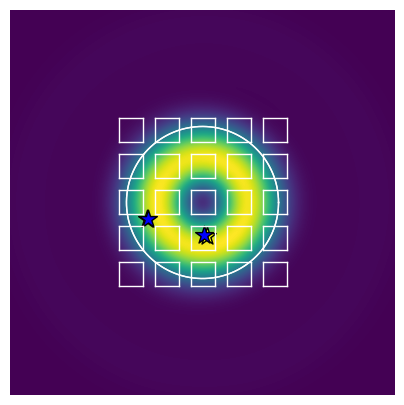

In [29]:
exCum = np.sum(exPSF, 0)

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1, 1, 1)
ax.imshow(exCum)
fovR = 400
ax.set_xlim([511-fovR, 511+fovR])
ax.set_ylim([511-fovR, 511+fovR])
plt.axis('off')

# add SPAD projection
startc = Nx/2 - SPADradiusP
SPADElsizeP = pxdim / M / pxsize
for j in range(N):
    startx = startc + j * pxpitch / M / pxsize
    for k in range(N):
        starty = startc + k * pxpitch / M / pxsize
        plt.plot([startx, startx + SPADElsizeP], [starty, starty], '-', color='white', linewidth=lw)
        plt.plot([startx, startx + SPADElsizeP], [starty + SPADElsizeP, starty + SPADElsizeP], '-', color='white', linewidth=lw)
        plt.plot([startx, startx], [starty, starty + SPADElsizeP], '-', color='white', linewidth=lw)
        plt.plot([startx + SPADElsizeP, startx + SPADElsizeP], [starty, starty + SPADElsizeP], '-', color='white', linewidth=lw)

# add fluorophore
for j in range(Nfluorophores):
    plt.scatter(fcoord[j][1], fcoord[j][0], color='yellow', marker='*', edgecolors='black', s=180)
    #plt.text(fcoord[j][1], fcoord[j][0], str(j))

# add fitted position
for j in range(Nfluorophores):
    plt.scatter(fitcoord[j][1], fitcoord[j][0], color='blue', marker='*', edgecolors='black', s=180)
    #plt.text(fcoord[j][1], fcoord[j][0], str(j))

# add excitation region
phi = np.linspace(0, 2*np.pi, 250)
rad = rad75 # px
for j in range(Nfluorophores):
    plt.plot(511 + rad * np.cos(phi), 511 + rad * np.sin(phi), color='white', linewidth=lw)
    #plt.text(fcoord[j][1], fcoord[j][0], str(j))
